# Mount To Drive & Import Libraries

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
import pandas
import torch
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from tqdm import tqdm
import torch.nn as nn
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence

!pip install sentence_transformers

from sentence_transformers import SentenceTransformer

     |████████████████████████████████| 79 kB 3.2 MB/s 
     |████████████████████████████████| 4.0 MB 9.1 MB/s 
     |████████████████████████████████| 1.2 MB 41.0 MB/s 
     |████████████████████████████████| 77 kB 5.9 MB/s 
     |████████████████████████████████| 596 kB 37.4 MB/s 
     |████████████████████████████████| 6.6 MB 10.0 MB/s 
     |████████████████████████████████| 895 kB 37.4 MB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.0-py3-none-any.whl size=120747 sha256=3358f78e208c5feea528c99030209f56ff386658ac8c687b1f40e9b8385609cf
  Stored in directory: /root/.cache/pip/wheels/83/c0/df/b6873ab7aac3f2465aa9144b6b4c41c4391cfecc027c8b07e7
Successfully built sentence-transformers
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


# Phrasebank DataLoader

In [ ]:
# For Downstream Data - Phrasebank
!mkdir downstream_data_zip
!mkdir downstream_data

!cp /content/drive/MyDrive/11785_Project/Programming/Data/phrasebank.zip downstream_data_zip

!unzip -q downstream_data_zip/*.zip -d downstream_data

In [ ]:
from pandas.core.frame import DataFrame
class LibriSamplesPhrasebank(torch.utils.data.Dataset):
    def __init__(self, data:DataFrame, convert_label_to_int=True, return_labels=False, sentence_to_vec:dict=None):
        """
        data:DataFrame
            This is the data split from the all-data.csv in the Financial Phrase Bank
        
        convert_label_to_int:bool
            If this is true, then:
                 negative = -1
                 neutral  =  0
                 positive =  1
        
        sentence_to_vec:dict
            If this value is present, then dictionary of sentence to vector mappings.
        """
        # Simply reading in the csv
        self.X = data["sentence"].to_numpy()
        self.unresolved = set()
        # Convert the sentences to vectors if a dictionary is provided
        if sentence_to_vec != None:
            new_X = []
            for sentence in self.X:
                vector = sentence_to_vec.get((sentence,), None)
                if vector == None:
                    # self.unresolved.add(sentence)
                    # print("The dictionary contains no vector for the sentence: \n{}".format(sentence))
                    # continue
                    raise Exception("The dictionary contains no vector for the sentence: \n{}".format(sentence))
                    return
                new_X.append(vector)
            self.X = np.array(new_X)
        else:
            new_X = []
            default_model = SentenceTransformer('sentence-transformers/paraphrase-MiniLM-L6-v2')
            for sentence in self.X:
                vector = default_model.encode(sentence) # numpy.array D=384
                new_X.append(torch.from_numpy(vector))
            self.X = np.array(new_X)

        # Check if we should be returning labels (Not necessary for generating the BERT Emedding)
        self.return_labels = return_labels
        if return_labels:
            self.Y = data["label"].to_numpy()
            # Probably will want to convert the data into numeric form for easier handling
            if convert_label_to_int:
                new_Y = np.ones(len(self.Y), dtype=np.int8)
                new_Y[self.Y == "negative"] = 0
                new_Y[self.Y == "positive"] = 2
                self.Y = torch.from_numpy(new_Y)

    def get_unresolved(self):
        return self.unresolved

    def __len__(self):
        """
        Get the size of the data.
        """
        return len(self.X)
    
    def __getitem__(self, ind):
        """
        if self.return_labels==True, then this will return the sentence and corresponding label,
        otherwise this will return only the sentence
        """
        if self.return_labels:
            return self.X[ind], self.Y[ind]
        else:
            return self.X[ind]

class LibriSamplesPhrasebankWordEmbedding(torch.utils.data.Dataset):
    def __init__(self, data:DataFrame, convert_label_to_int=True, return_labels=False, word_to_vec=None):
        """
        data:DataFrame
            This is the data split from the all-data.csv in the Financial Phrase Bank
        
        convert_label_to_int:bool
            If this is true, then:
                 negative = -1
                 neutral  =  0
                 positive =  1
        
        word_to_vec: lambda
            If this value is present, then dictionary of word to vector mappings.
        """
        # Simply reading in the csv
        self.X = data["sentence"].to_numpy()

        # Convert the sentences to vectors if a dictionary is provided
        if word_to_vec != None:
            new_X = []
            new_lenX = []
            for sentence in self.X:
                word_vec = []
                for word in sentence.split():
                    word = word.lower()
                    try:
                        vector = word_to_vec(word)
                        word_vec.append(vector)
                    except:
                        # print(f'Cannot embed: {word}')
                        pass

                    # if word in word_to_vec.keys():
                    #     vector = word_to_vec[word]
                    #     word_vec.append(vector)
                if len(word_vec) > 0:
                    new_X.append(np.array(word_vec))
                    new_lenX.append(len(word_vec))
                # else:
                #     print(f'could not recog any word in: {sentence}')
            self.X = np.array(new_X)

        # Check if we should be returning labels (Not necessary for generating the BERT Emedding)
        self.return_labels = return_labels
        if return_labels:
            self.Y = data["label"].to_numpy()
            # Probably will want to convert the data into numeric form for easier handling
            if convert_label_to_int:
                new_Y = np.ones(len(self.Y), dtype=np.int64)
                new_Y[self.Y == "negative"] = 0
                new_Y[self.Y == "positive"] = 2
                self.Y = new_Y

    def __len__(self):
        """
        Get the size of the data.
        """
        return len(self.X)
    
    def __getitem__(self, ind):
        """
        if self.return_labels==True, then this will return the sentence and corresponding label,
        otherwise this will return only the sentence
        """
        if self.return_labels:
            return torch.from_numpy(self.X[ind]), self.Y[ind]
        else:
            return torch.from_numpy(self.X[ind])
    
    def labeled_collate_fn(batch):
        batch_x = [x for x,y in batch]
        batch_y = [y for x,y in batch]

        batch_x_pad = pad_sequence(batch_x, batch_first=True)
        lengths_x = [len(x) for x in batch_x]

        return batch_x_pad, torch.tensor(lengths_x), torch.tensor(batch_y)
    
    def unlabeled_collate_fn(batch):
        batch_x = batch

        batch_x_pad = pad_sequence(batch_x, batch_first=True)
        lengths_x = [len(x) for x in batch_x]

        return batch_x_pad, torch.tensor(lengths_x)

In [ ]:
# Test the dataloader
csv_path = "/content/downstream_data/all-data.csv"
df = pandas.read_csv(csv_path, encoding="ISO-8859-1", names=["label", "sentence"])
phrasebank_data = LibriSamplesPhrasebank(df, convert_label_to_int=True, return_labels=True)
phrasebank_loader = DataLoader(phrasebank_data, batch_size=128, shuffle=False) #Shuffle is false just for demonstration purposes
for i, data in enumerate(phrasebank_loader):
    sentences, labels = data
    for sentence, label in zip(sentences, labels):
        print(f"{sentence}\nLabel={label}\n")
    break

Downloading:   0%|          | 0.00/690 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/3.69k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/629 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/122 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/229 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

KeyboardInterrupt: ignored

# Confusion Matrix

This code is borrowed heavily from [this tutorial](https://www.stackvidhya.com/plot-confusion-matrix-in-python-and-why/).

In [ ]:
def plot_confusion(y_true, y_pred):
    #Generate the confusion matrix
    cf_matrix = confusion_matrix(y_true, y_pred, labels=[-1,0,1])
    cf_matrix = cf_matrix / np.sum(cf_matrix)
    # From dataloader:
        # negative = -1
        # neutral  =  0
        # positive =  1
    ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues')

    ax.set_title('Confusion Matrix with labels');
    ax.set_xlabel('Predicted Values')
    ax.set_ylabel('Actual Values');

    ## Ticket labels - List must be in alphabetical order
    ax.xaxis.set_ticklabels(['negative','neutral','positive'])
    ax.yaxis.set_ticklabels(['negative','neutral','positive'])

    ## Display the visualization of the Confusion Matrix.
    plt.show()

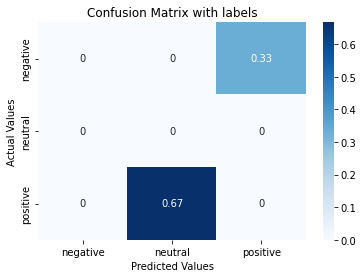

In [ ]:
# Just some unit testing
y_true = [-1, 1, 1]
y_pred = [1, 0, 0]
plot_confusion(y_true, y_pred)
# Yup, checks out

# ROC Curves (TODO)

[Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html)

[Example](https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html#sphx-glr-auto-examples-model-selection-plot-roc-py)

# Modelling

In [ ]:
csv_path = "/content/downstream_data/all-data.csv"
df = pandas.read_csv(csv_path, encoding="ISO-8859-1", names=["label", "sentence"])

df_train, df_val = train_test_split(df, test_size = 0.1, random_state = 10)
len(df_train), len(df_val)

(4361, 485)

# Sentence Embedding

In [ ]:
class SentenceModel(nn.Module):
    def __init__(self, embedding_size: int, classes: int):
        super(SentenceModel, self).__init__()
        self.classification = nn.Linear(
            in_features=embedding_size,
            out_features=classes,
        )
        self.softmax = nn.Softmax(dim = 1)

    def forward(self, inputs_):
        x = self.classification(inputs_)
        x = self.softmax(x)
        return x

In [ ]:
lr = 1e-3
epochs = 100
classes = 3

# sentence_to_vec = None
# embedding_width = 384
# sentence_to_vec = torch.load('/content/drive/MyDrive/11785_Project/Programming/embeddings/pre_trained_avg_distilbert-base-uncased_0_1651112779_last_layer_distil_roberta.json')
# embedding_width = 768
# sentence_to_vec = torch.load('/content/drive/MyDrive/11785_Project/Programming/embeddings/pre_trained_CLS_distilroberta-base_0_1651152434_last_layer_distil_roberta.json')
# embedding_width = 768
sentence_to_vec = torch.load('/content/drive/MyDrive/11785_Project/Programming/embeddings/pre_trained_avg_distilroberta-base_0_1651152434_last_layer_distil_roberta.json')
embedding_width = 768
# sentence_to_vec = torch.load('/content/drive/MyDrive/11785_Project/Programming/embeddings/avg_retrained_distilroberta-base_0_1651228176.json')
# embedding_width = 768
# sentence_to_vec = torch.load('/content/drive/MyDrive/11785_Project/Programming/embeddings/bert-base-uncased-baseline_0_1651128098_last_layer_distil_roberta.json')
# embedding_width = 768
# sentence_to_vec = torch.load('/content/drive/MyDrive/11785_Project/Programming/embeddings/bert-base-uncased-trained_0_1651200461_last_layer_distil_roberta.json')
# embedding_width = 768
# sentence_to_vec = torch.load('/content/drive/MyDrive/11785_Project/Programming/embeddings/distilbert-base-uncased_0_1651117834_distilbert-base-uncased_BASELINE.json')
# embedding_width = 768
# sentence_to_vec = torch.load('/content/drive/MyDrive/11785_Project/Programming/embeddings/distilbert-base-uncased_1_1651148962_distilbert-base-uncased.json')
# embedding_width = 768
# sentence_to_vec = torch.load('/content/drive/MyDrive/11785_Project/Programming/embeddings/distilbert-base-multilingual-cased_0_1651127952_last_layer_distil_bert-mult-cased-base.json')
# embedding_width = 768
# sentence_to_vec = torch.load('/content/drive/MyDrive/11785_Project/Programming/embeddings/distilbert-base-multilingual-cased_0_1651155335_last_layer_distil_bert-mult-cased.json')
# embedding_width = 768



all_data = LibriSamplesPhrasebank(df, convert_label_to_int=True, return_labels=True, sentence_to_vec=sentence_to_vec)
print(len(all_data.unresolved))

train_data = LibriSamplesPhrasebank(df_train, convert_label_to_int=True, return_labels=True, sentence_to_vec=sentence_to_vec)
train_loader = DataLoader(train_data, batch_size=128)

val_data = LibriSamplesPhrasebank(df_val, convert_label_to_int=True, return_labels=True, sentence_to_vec=sentence_to_vec)
val_loader = DataLoader(val_data, batch_size=128)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


0


In [ ]:

model = SentenceModel(embedding_width, classes).cuda()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr) # LR from https://arxiv.org/pdf/1903.10676.pdf
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, epochs, eta_min=lr*0.05)

def train_model(model):
    torch.cuda.empty_cache()
    model.train()
    total_loss = 0
    batch_bar = tqdm(total=len(train_loader), dynamic_ncols=True, leave=False, position=0, desc='Train') 

    for i, (x, y) in enumerate(train_loader):
        optimizer.zero_grad()

        x = x.cuda()
        y = y.type(torch.LongTensor)
        y = y.cuda()

        # Don't be surprised - we just wrap these two lines to make it work for FP16
        h = model(x)
        loss = criterion(h, y)

        # Update loss as we go
        total_loss += float(loss)

        # tqdm lets you add some details so you can monitor training as you train.
        batch_bar.set_postfix(
            loss="{:.04f}".format(float(total_loss / (i + 1))))
        
        # Another couple things you need for FP16. 
        loss.backward() # This is a replacement for loss.backward()
        optimizer.step() # This is a replacement for optimizer.step()
        batch_bar.update() # Update tqdm bar
    scheduler.step()
    batch_bar.close() # You need this to close the tqdm bar

    loss = float(total_loss / len(train_loader))
    print("Epoch {}/{}: Train Loss {:.04f}".format(
        epoch + 1,
        epochs,
        loss))

    return loss

def eval_model(model):
    torch.cuda.empty_cache()
    model.eval()
    batch_bar = tqdm(total=len(val_loader), dynamic_ncols=True, position=0, leave=False, desc='Val')
    dists = []
    correct = 0.0
    total = 0.0

    for i, data in enumerate(val_loader):
        x, y = data
        x = x.cuda()
        y = y.type(torch.LongTensor)
        y = y.cuda()

        h = model(x)
        preds = torch.argmax(h, axis=1, keepdims=False)
        # print(f'preds: {preds}')
        # print(f'y: {y}')
        correct += (preds == y).float().sum()
        total += len(preds)
        batch_bar.update()
    
    batch_bar.close()

    score = correct / total
    print(f"Validation acc: {score}")
    return score

In [ ]:
for epoch in range(epochs):
    lr = float(optimizer.param_groups[0]['lr'])
    loss = train_model(model)
    score = eval_model(model)

Epoch 1/100: Train Loss 1.0138


Validation acc: 0.6082474589347839


Epoch 2/100: Train Loss 0.9448


Validation acc: 0.6371134519577026


Epoch 3/100: Train Loss 0.9199


Validation acc: 0.6762886643409729


Epoch 4/100: Train Loss 0.9066


Validation acc: 0.6762886643409729


Epoch 5/100: Train Loss 0.8978


Validation acc: 0.6845360994338989


Epoch 6/100: Train Loss 0.8909


Validation acc: 0.6948453783988953


Epoch 7/100: Train Loss 0.8848


Validation acc: 0.6948453783988953


Epoch 8/100: Train Loss 0.8793


Validation acc: 0.6989691257476807


Epoch 9/100: Train Loss 0.8742


Validation acc: 0.6989691257476807


Epoch 10/100: Train Loss 0.8696


Validation acc: 0.6989691257476807


Epoch 11/100: Train Loss 0.8655


Validation acc: 0.7030928134918213


Epoch 12/100: Train Loss 0.8618


Validation acc: 0.7072165012359619


Epoch 13/100: Train Loss 0.8585


Validation acc: 0.7072165012359619


Epoch 14/100: Train Loss 0.8554


Validation acc: 0.7072165012359619


Epoch 15/100: Train Loss 0.8527


Validation acc: 0.7154639363288879


Epoch 16/100: Train Loss 0.8501


Validation acc: 0.7154639363288879


Epoch 17/100: Train Loss 0.8477


Validation acc: 0.7175257802009583


Epoch 18/100: Train Loss 0.8455


Validation acc: 0.7195876836776733


Epoch 19/100: Train Loss 0.8433


Validation acc: 0.7195876836776733


Epoch 20/100: Train Loss 0.8413


Validation acc: 0.723711371421814


Epoch 21/100: Train Loss 0.8391


Validation acc: 0.7278350591659546


Epoch 22/100: Train Loss 0.8364


Validation acc: 0.7278350591659546


Epoch 23/100: Train Loss 0.8326


Validation acc: 0.7257732152938843


Epoch 24/100: Train Loss 0.8281


Validation acc: 0.7278350591659546


Epoch 25/100: Train Loss 0.8252


Validation acc: 0.73195880651474


Epoch 26/100: Train Loss 0.8225


Validation acc: 0.7340206503868103


Epoch 27/100: Train Loss 0.8199


Validation acc: 0.7340206503868103


Epoch 28/100: Train Loss 0.8175


Validation acc: 0.7422680854797363


Epoch 29/100: Train Loss 0.8152


Validation acc: 0.7381443381309509


Epoch 30/100: Train Loss 0.8130


Validation acc: 0.746391773223877


Epoch 31/100: Train Loss 0.8110


Validation acc: 0.7422680854797363


Epoch 32/100: Train Loss 0.8090


Validation acc: 0.746391773223877


Epoch 33/100: Train Loss 0.8070


Validation acc: 0.7505155205726624


Epoch 34/100: Train Loss 0.8052


Validation acc: 0.754639208316803


Epoch 35/100: Train Loss 0.8033


Validation acc: 0.7608247995376587


Epoch 36/100: Train Loss 0.8016


Validation acc: 0.7608247995376587


Epoch 37/100: Train Loss 0.7999


Validation acc: 0.7608247995376587


Epoch 38/100: Train Loss 0.7982


Validation acc: 0.7608247995376587


Epoch 39/100: Train Loss 0.7966


Validation acc: 0.762886643409729


Epoch 40/100: Train Loss 0.7950


Validation acc: 0.7649484872817993


Epoch 41/100: Train Loss 0.7934


Validation acc: 0.7670103311538696


Epoch 42/100: Train Loss 0.7919


Validation acc: 0.7690721750259399


Epoch 43/100: Train Loss 0.7904


Validation acc: 0.771134078502655


Epoch 44/100: Train Loss 0.7890


Validation acc: 0.771134078502655


Epoch 45/100: Train Loss 0.7876


Validation acc: 0.771134078502655


Epoch 46/100: Train Loss 0.7862


Validation acc: 0.7731959223747253


Epoch 47/100: Train Loss 0.7849


Validation acc: 0.777319610118866


Epoch 48/100: Train Loss 0.7836


Validation acc: 0.777319610118866


Epoch 49/100: Train Loss 0.7824


Validation acc: 0.777319610118866


Epoch 50/100: Train Loss 0.7813


Validation acc: 0.777319610118866


Epoch 51/100: Train Loss 0.7801


Validation acc: 0.777319610118866


Epoch 52/100: Train Loss 0.7791


Validation acc: 0.7814433574676514


Epoch 53/100: Train Loss 0.7780


Validation acc: 0.7835052013397217


Epoch 54/100: Train Loss 0.7771


Validation acc: 0.785567045211792


Epoch 55/100: Train Loss 0.7761


Validation acc: 0.7835052013397217


Epoch 56/100: Train Loss 0.7752


Validation acc: 0.7835052013397217


Epoch 57/100: Train Loss 0.7744


Validation acc: 0.7835052013397217


Epoch 58/100: Train Loss 0.7736


Validation acc: 0.7835052013397217


Epoch 59/100: Train Loss 0.7728


Validation acc: 0.7835052013397217


Epoch 60/100: Train Loss 0.7721


Validation acc: 0.7835052013397217


Epoch 61/100: Train Loss 0.7714


Validation acc: 0.785567045211792


Epoch 62/100: Train Loss 0.7707


Validation acc: 0.785567045211792


Epoch 63/100: Train Loss 0.7701


Validation acc: 0.785567045211792


Epoch 64/100: Train Loss 0.7695


Validation acc: 0.785567045211792


Epoch 65/100: Train Loss 0.7689


Validation acc: 0.785567045211792


Epoch 66/100: Train Loss 0.7684


Validation acc: 0.785567045211792


Epoch 67/100: Train Loss 0.7679


Validation acc: 0.785567045211792


Epoch 68/100: Train Loss 0.7674


Validation acc: 0.785567045211792


Epoch 69/100: Train Loss 0.7670


Validation acc: 0.785567045211792


Epoch 70/100: Train Loss 0.7666


Validation acc: 0.785567045211792


Epoch 71/100: Train Loss 0.7662


Validation acc: 0.785567045211792


Epoch 72/100: Train Loss 0.7658


Validation acc: 0.785567045211792


Epoch 73/100: Train Loss 0.7655


Validation acc: 0.7835052013397217


Epoch 74/100: Train Loss 0.7651


Validation acc: 0.7835052013397217


Epoch 75/100: Train Loss 0.7648


Validation acc: 0.7835052013397217


Epoch 76/100: Train Loss 0.7645


Validation acc: 0.7835052013397217


Epoch 77/100: Train Loss 0.7642


Validation acc: 0.7835052013397217


Epoch 78/100: Train Loss 0.7640


Validation acc: 0.7835052013397217


Epoch 79/100: Train Loss 0.7637


Validation acc: 0.7814433574676514


Epoch 80/100: Train Loss 0.7635


Validation acc: 0.7814433574676514


Epoch 81/100: Train Loss 0.7633


Validation acc: 0.7814433574676514


Epoch 82/100: Train Loss 0.7631


Validation acc: 0.7835052013397217


Epoch 83/100: Train Loss 0.7629


Validation acc: 0.7835052013397217


Epoch 84/100: Train Loss 0.7628


Validation acc: 0.7835052013397217


Epoch 85/100: Train Loss 0.7626


Validation acc: 0.7835052013397217


Epoch 86/100: Train Loss 0.7624


Validation acc: 0.7835052013397217


Epoch 87/100: Train Loss 0.7623


Validation acc: 0.7835052013397217


Epoch 88/100: Train Loss 0.7622


Validation acc: 0.7835052013397217


Epoch 89/100: Train Loss 0.7621


Validation acc: 0.7835052013397217


Epoch 90/100: Train Loss 0.7619


Validation acc: 0.7835052013397217


Epoch 91/100: Train Loss 0.7618


Validation acc: 0.7835052013397217


Epoch 92/100: Train Loss 0.7617


Validation acc: 0.7835052013397217


Epoch 93/100: Train Loss 0.7616


Validation acc: 0.7835052013397217


Epoch 94/100: Train Loss 0.7616


Validation acc: 0.7835052013397217


Epoch 95/100: Train Loss 0.7615


Validation acc: 0.7835052013397217


Epoch 96/100: Train Loss 0.7614


Validation acc: 0.7835052013397217


Epoch 97/100: Train Loss 0.7613


Validation acc: 0.7835052013397217


Epoch 98/100: Train Loss 0.7612


Validation acc: 0.7835052013397217


Epoch 99/100: Train Loss 0.7612


Validation acc: 0.7835052013397217


Epoch 100/100: Train Loss 0.7611


Validation acc: 0.7835052013397217


# Word Embedding

In [ ]:
class WordModel(nn.Module):
    def __init__(self, embedding_size: int, classes: int):
        super(WordModel, self).__init__()
        # self.lstm = nn.LSTM(embedding_size, embedding_size, num_layers=2, bidirectional=True, batch_first=True)
        # self.classification = nn.Linear(
        #     in_features=embedding_size*2,
        #     out_features=embedding_size,
        # )
        self.classification = nn.Linear(
            in_features=embedding_size,
            out_features=embedding_size,
        )
        self.relu = nn.ReLU()
        self.classification2 = nn.Linear(
            in_features=embedding_size,
            out_features=classes,
        )
        self.softmax = nn.Softmax(dim = 1)

    def forward(self, inputs_, inputs_len):
        # print(f'input shape - {len(inputs_.shape)}: {inputs_.shape}')
        # if len(inputs_.shape) == 4:
        #     inputs_ = torch.squeeze(inputs_, dim=3)
        # print(f'input - {inputs_.shape}')
        # packed_input = pack_padded_sequence(inputs_, inputs_len, enforce_sorted=False, batch_first=True)
        # lstm_output, _ = self.lstm(packed_input)
        # padded_output, _ = pad_packed_sequence(lstm_output, batch_first=True)
        # # print(f'padded_output - {padded_output.shape}')
        # lstm_embedding = padded_output[:,-1,:] # Or any in the sequence is fine
        # print(f'lstm_embedding - {lstm_embedding.shape}')
        # x = self.classification(lstm_embedding)
        x = self.classification(inputs_)
        x = self.relu(x)
        x = self.classification2(x)
        x = self.softmax(x)
        # print(f'x - {x.shape}')
        return x

In [ ]:
# Models

EMBED_DIMENSION = 300
EMBED_MAX_NORM = 1

class CBOW_Model(nn.Module):
    """
    Implementation of CBOW model described in paper:
    https://arxiv.org/abs/1301.3781
    """
    def __init__(self, vocab_size: int):
        super(CBOW_Model, self).__init__()
        self.embeddings = nn.Embedding(
            num_embeddings=vocab_size,
            embedding_dim=EMBED_DIMENSION,
            max_norm=EMBED_MAX_NORM,
        )
        self.linear = nn.Linear(
            in_features=EMBED_DIMENSION,
            out_features=vocab_size,
        )

    def forward(self, inputs_):
        x = self.embeddings(inputs_)
        x = x.mean(axis=1)
        x = self.linear(x)
        return x


class SkipGram_Model(nn.Module):
    """
    Implementation of Skip-Gram model described in paper:
    https://arxiv.org/abs/1301.3781
    """
    def __init__(self, vocab_size: int):
        super(SkipGram_Model, self).__init__()
        self.embeddings = nn.Embedding(
            num_embeddings=vocab_size,
            embedding_dim=EMBED_DIMENSION,
            max_norm=EMBED_MAX_NORM,
        )
        self.linear = nn.Linear(
            in_features=EMBED_DIMENSION,
            out_features=vocab_size,
        )

    def forward(self, inputs_):
        # print(f'input shape: {inputs_.shape}')
        # print(f'input: {inputs_}')
        x = self.embeddings(inputs_)
        x = self.linear(x)
        return x

model = torch.load('/content/drive/MyDrive/11785_Project/Programming/Data/Project/word2vec/cbow_300/model.pt')
vocab = torch.load('/content/drive/MyDrive/11785_Project/Programming/Data/Project/word2vec/cbow_300/vocab.pt')

vocab_words = []

for w in vocab.get_stoi().keys():
    vocab_words.append(w)

# embedding from first model layer
embeddings = list(model.parameters())[0]
embeddings = embeddings.cpu().detach().numpy()

# normalization
norms = (embeddings ** 2).sum(axis=1) ** (1 / 2)
norms = np.reshape(norms, (len(norms), 1))
embeddings_norm = embeddings / norms
embeddings_norm.shape

def get_word_embedding(word: str):
    word_id = vocab[word]
    if word_id == 0:
        # print("Out of vocabulary word")
        return torch.zeros(embeddings_norm.shape[1], 1)

    word_vec = embeddings_norm[word_id]
    word_vec = np.reshape(word_vec, (len(word_vec), 1))
    return word_vec

word_to_vec = {}

for word in vocab_words:
    word_to_vec[word] = get_word_embedding(word)

In [ ]:
# print(type(word_to_vec))
# print(len(word_to_vec))
# print(list(word_to_vec.items())[0])

# print(word_to_vec.keys())

import gensim
import gensim.downloader as api
word_model = gensim.models.KeyedVectors.load_word2vec_format('/content/drive/MyDrive/11785_Project/Programming/embeddings/word_test/GoogleNews-vectors-negative300.bin.gz', binary=True)


In [ ]:
def gensim_word_to_vec(word):
    return word_model[word]

gensim_word_to_vec('experiences')

array([-9.27734375e-02,  1.33789062e-01,  5.34667969e-02, -1.81884766e-02,
       -3.51562500e-02,  9.42382812e-02, -4.33349609e-03, -2.41994858e-05,
        2.05078125e-01, -1.00097656e-01, -2.96630859e-02,  1.28906250e-01,
        1.07421875e-01,  7.91015625e-02,  1.48925781e-02,  1.48437500e-01,
       -1.06445312e-01,  4.60937500e-01,  1.37695312e-01, -2.30468750e-01,
        3.51562500e-02,  2.10937500e-01, -1.87988281e-02,  7.20214844e-03,
       -6.93359375e-02, -1.64062500e-01,  1.21093750e-01,  1.25976562e-01,
       -1.18652344e-01, -2.20703125e-01, -1.08886719e-01, -6.73828125e-02,
       -9.22851562e-02,  1.40625000e-01, -9.57031250e-02,  6.22558594e-02,
        1.08398438e-01, -9.52148438e-03, -1.37939453e-02, -1.59179688e-01,
       -7.71484375e-02,  1.78710938e-01, -1.43554688e-01,  1.37695312e-01,
        2.36328125e-01, -3.88183594e-02, -1.09863281e-01,  1.83593750e-01,
       -4.32128906e-02, -4.37011719e-02, -9.32617188e-02, -3.05175781e-02,
       -1.20605469e-01,  

In [ ]:
lr = 1e-3
epochs = 50
embedding_width = 300
classes = 3

train_data = LibriSamplesPhrasebankWordEmbedding(df_train, convert_label_to_int=True, return_labels=True, word_to_vec=gensim_word_to_vec)
train_loader = DataLoader(train_data, batch_size=128, collate_fn=LibriSamplesPhrasebankWordEmbedding.labeled_collate_fn)

val_data = LibriSamplesPhrasebankWordEmbedding(df_val, convert_label_to_int=True, return_labels=True, word_to_vec=gensim_word_to_vec)
val_loader = DataLoader(val_data, batch_size=128, collate_fn=LibriSamplesPhrasebankWordEmbedding.labeled_collate_fn)

model = WordModel(embedding_width, classes).cuda()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr) # LR from https://arxiv.org/pdf/1903.10676.pdf

def train_model(model):
    torch.cuda.empty_cache()
    model.train()
    total_loss = 0
    batch_bar = tqdm(total=len(train_loader), dynamic_ncols=True, leave=False, position=0, desc='Train') 

    for i, (x, lx, y) in enumerate(train_loader):
        optimizer.zero_grad()

        x = x.cuda()
        y = y.type(torch.LongTensor)
        y = y.cuda()

        x = torch.mean(x, dim=1)

        # Don't be surprised - we just wrap these two lines to make it work for FP16
        h = model(x, lx)
        loss = criterion(h, y)

        # Update loss as we go
        total_loss += float(loss)

        # tqdm lets you add some details so you can monitor training as you train.
        batch_bar.set_postfix(
            loss="{:.04f}".format(float(total_loss / (i + 1))))
        
        loss.backward() 
        optimizer.step() 
        batch_bar.update() 
    batch_bar.close()

    loss = float(total_loss / len(train_loader))
    print("Epoch {}/{}: Train Loss {:.04f}".format(
        epoch + 1,
        epochs,
        loss))

    return loss

def eval_model(model):
    torch.cuda.empty_cache()
    model.eval()
    batch_bar = tqdm(total=len(val_loader), dynamic_ncols=True, position=0, leave=False, desc='Val')
    dists = []
    correct = 0.0
    zeros = 0.0
    ones = 0.0
    twos = 0.0
    pred_zeros = 0.0
    pred_ones = 0.0
    pred_twos = 0.0
    total = 0.0

    for i, data in enumerate(val_loader):
        x, lx, y = data
        x = x.cuda()
        y = y.type(torch.LongTensor)
        y = y.cuda()

        x = torch.mean(x, dim=1)

        h = model(x, lx)
        preds = torch.argmax(h, axis=1, keepdims=False)
        correct += torch.sum(preds == y)
        zeros += torch.sum(y == 0)
        ones += torch.sum(y == 1)
        twos += torch.sum(y == 2)
        pred_zeros += torch.sum(preds == 0)
        pred_ones += torch.sum(preds == 1)
        pred_twos += torch.sum(preds == 2)
        total += len(preds)
        batch_bar.update()
    
    batch_bar.close()

    score = correct / total
    print(f"Validation acc: {score}")
    # print(f"y_zeros: {zeros/total}, y_ones: {ones/total}, y_twos: {twos/total}")
    # print(f"pred_zeros: {pred_zeros/total}, pred_ones: {pred_ones/total}, pred_twos: {pred_twos/total}")
    return score

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:112: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


In [ ]:
print(len(train_loader))

35


In [ ]:
for epoch in range(epochs):
    lr = float(optimizer.param_groups[0]['lr'])
    loss = train_model(model)
    score = eval_model(model)

Epoch 1/50: Train Loss 1.0244


Validation acc: 0.6082474589347839


Epoch 2/50: Train Loss 0.9456


Validation acc: 0.6639175415039062


Epoch 3/50: Train Loss 0.9125


Validation acc: 0.6804124116897583


Epoch 4/50: Train Loss 0.9008


Validation acc: 0.6824742555618286


Epoch 5/50: Train Loss 0.8915


Validation acc: 0.6845360994338989


Epoch 6/50: Train Loss 0.8833


Validation acc: 0.6845360994338989


Epoch 7/50: Train Loss 0.8749


Validation acc: 0.6907216906547546


Epoch 8/50: Train Loss 0.8647


Validation acc: 0.6907216906547546


Epoch 9/50: Train Loss 0.8532


Validation acc: 0.6948453783988953


Epoch 10/50: Train Loss 0.8431


Validation acc: 0.6989691257476807


Epoch 11/50: Train Loss 0.8337


Validation acc: 0.7134020924568176


Epoch 12/50: Train Loss 0.8259


Validation acc: 0.7175257802009583


Epoch 13/50: Train Loss 0.8193


Validation acc: 0.7257732152938843


Epoch 14/50: Train Loss 0.8134


Validation acc: 0.7257732152938843


Epoch 15/50: Train Loss 0.8081


Validation acc: 0.7257732152938843


Epoch 16/50: Train Loss 0.8033


Validation acc: 0.7257732152938843


Epoch 17/50: Train Loss 0.7987


Validation acc: 0.740206241607666


Epoch 18/50: Train Loss 0.7944


Validation acc: 0.7443299293518066


Epoch 19/50: Train Loss 0.7902


Validation acc: 0.746391773223877


Epoch 20/50: Train Loss 0.7862


Validation acc: 0.7525773644447327


Epoch 21/50: Train Loss 0.7824


Validation acc: 0.754639208316803


Epoch 22/50: Train Loss 0.7788


Validation acc: 0.7525773644447327


Epoch 23/50: Train Loss 0.7754


Validation acc: 0.762886643409729


Epoch 24/50: Train Loss 0.7722


Validation acc: 0.7608247995376587


Epoch 25/50: Train Loss 0.7690


Validation acc: 0.7587628960609436


Epoch 26/50: Train Loss 0.7661


Validation acc: 0.762886643409729


Epoch 27/50: Train Loss 0.7632


Validation acc: 0.762886643409729


Epoch 28/50: Train Loss 0.7604


Validation acc: 0.762886643409729


Epoch 29/50: Train Loss 0.7577


Validation acc: 0.7608247995376587


Epoch 30/50: Train Loss 0.7552


Validation acc: 0.7608247995376587


Epoch 31/50: Train Loss 0.7528


Validation acc: 0.7649484872817993


Epoch 32/50: Train Loss 0.7505


Validation acc: 0.7649484872817993


Epoch 33/50: Train Loss 0.7484


Validation acc: 0.762886643409729


Epoch 34/50: Train Loss 0.7464


Validation acc: 0.762886643409729


Epoch 35/50: Train Loss 0.7444


Validation acc: 0.7649484872817993


Epoch 36/50: Train Loss 0.7425


Validation acc: 0.7649484872817993


Epoch 37/50: Train Loss 0.7407


Validation acc: 0.7670103311538696


Epoch 38/50: Train Loss 0.7390


Validation acc: 0.7731959223747253


Epoch 39/50: Train Loss 0.7374


Validation acc: 0.7752577662467957


Epoch 40/50: Train Loss 0.7357


Validation acc: 0.7752577662467957


Epoch 41/50: Train Loss 0.7341


Validation acc: 0.7793814539909363


Epoch 42/50: Train Loss 0.7325


Validation acc: 0.7814433574676514


Epoch 43/50: Train Loss 0.7310


Validation acc: 0.785567045211792


Epoch 44/50: Train Loss 0.7295


Validation acc: 0.7876288890838623


Epoch 45/50: Train Loss 0.7280


Validation acc: 0.7917525768280029


Epoch 46/50: Train Loss 0.7265


Validation acc: 0.7896907329559326


Epoch 47/50: Train Loss 0.7251


Validation acc: 0.7896907329559326


Epoch 48/50: Train Loss 0.7237


Validation acc: 0.7896907329559326


Epoch 49/50: Train Loss 0.7223


Validation acc: 0.7896907329559326


Epoch 50/50: Train Loss 0.7209


Validation acc: 0.793814480304718


In [ ]:
for epoch in range(epochs):
    lr = float(optimizer.param_groups[0]['lr'])
    loss = train_model(model)
    score = eval_model(model)

Epoch 1/50: Train Loss 1.0986


Validation acc: 74.64462280273438


Epoch 2/50: Train Loss 1.0924


Validation acc: 74.64462280273438


Epoch 3/50: Train Loss 1.0865


Validation acc: 74.35123443603516


Epoch 4/50: Train Loss 1.0801


Validation acc: 74.51136016845703


Epoch 5/50: Train Loss 1.0735


Validation acc: 74.388427734375


Epoch 6/50: Train Loss 1.0674


Validation acc: 74.388427734375


Epoch 7/50: Train Loss 1.0620


Validation acc: 74.46383666992188


Epoch 8/50: Train Loss 1.0576


Validation acc: 74.35123443603516


Epoch 9/50: Train Loss 1.0526


Validation acc: 74.43594360351562


Epoch 10/50: Train Loss 1.0478


Validation acc: 74.43594360351562


Epoch 11/50: Train Loss 1.0432


Validation acc: 74.43594360351562


Epoch 12/50: Train Loss 1.0389


Validation acc: 74.43594360351562


Epoch 13/50: Train Loss 1.0346


Validation acc: 74.43594360351562


Epoch 14/50: Train Loss 1.0306


Validation acc: 74.43594360351562


Epoch 15/50: Train Loss 1.0267


Validation acc: 74.43594360351562


Epoch 16/50: Train Loss 1.0230


Validation acc: 74.43594360351562


Epoch 17/50: Train Loss 1.0195


Validation acc: 74.43594360351562


Epoch 18/50: Train Loss 1.0161


Validation acc: 74.43594360351562


Epoch 19/50: Train Loss 1.0129


Validation acc: 74.43594360351562


Epoch 20/50: Train Loss 1.0099


Validation acc: 74.4772720336914


Epoch 21/50: Train Loss 1.0071


Validation acc: 74.43594360351562


Epoch 22/50: Train Loss 1.0041


Validation acc: 74.4772720336914


Epoch 23/50: Train Loss 1.0026


Validation acc: 74.52478790283203


Epoch 24/50: Train Loss 0.9999


Validation acc: 74.4772720336914


Epoch 25/50: Train Loss 0.9970


Validation acc: 74.4772720336914


Epoch 26/50: Train Loss 0.9949


Validation acc: 74.51136016845703


Epoch 27/50: Train Loss 0.9927


Validation acc: 74.51136016845703


Epoch 28/50: Train Loss 0.9906


Validation acc: 74.51136016845703


Epoch 29/50: Train Loss 0.9888


Validation acc: 74.51136016845703


Epoch 30/50: Train Loss 0.9871


Validation acc: 74.51136016845703


Epoch 31/50: Train Loss 0.9855


Validation acc: 74.51136016845703


Epoch 32/50: Train Loss 0.9840


Validation acc: 74.51136016845703


Epoch 33/50: Train Loss 0.9826


Validation acc: 74.51136016845703


Epoch 34/50: Train Loss 0.9813


Validation acc: 74.51136016845703


Epoch 35/50: Train Loss 0.9800


Validation acc: 74.51136016845703


Epoch 36/50: Train Loss 0.9789


Validation acc: 74.51136016845703


Epoch 37/50: Train Loss 0.9778


Validation acc: 74.51136016845703


Epoch 38/50: Train Loss 0.9767


Validation acc: 74.51136016845703


Epoch 39/50: Train Loss 0.9757


Validation acc: 74.51136016845703


Epoch 40/50: Train Loss 0.9748


Validation acc: 74.51136016845703


Epoch 41/50: Train Loss 0.9739


Validation acc: 74.51136016845703


Epoch 42/50: Train Loss 0.9730


Validation acc: 74.51136016845703


Epoch 43/50: Train Loss 0.9723


Validation acc: 74.51136016845703


Epoch 44/50: Train Loss 0.9715


Validation acc: 74.51136016845703


Epoch 45/50: Train Loss 0.9708


Validation acc: 74.51136016845703


Epoch 46/50: Train Loss 0.9701


Validation acc: 74.51136016845703


Epoch 47/50: Train Loss 0.9695


Validation acc: 74.51136016845703


Epoch 48/50: Train Loss 0.9688


Validation acc: 74.51136016845703


Epoch 49/50: Train Loss 0.9683


Validation acc: 74.51136016845703


Epoch 50/50: Train Loss 0.9677


Validation acc: 74.51136016845703


In [ ]:
# Spotcheck

base_sentence_to_vec = torch.load('/content/drive/MyDrive/11785_Project/Programming/embeddings/distilbert-base-uncased_0_1651117834_distilbert-base-uncased_BASELINE.json')
trained_sentence_to_vec = torch.load('/content/drive/MyDrive/11785_Project/Programming/embeddings/distilbert-base-uncased_1_1651148962_distilbert-base-uncased.json')


In [ ]:

sentence1 = 'According to Gran , the company has no plans to move all production to Russia , although that is where the company is growing .'
sentence2 = 'Technopolis plans to develop in stages an area of no less than 100,000 square meters in order to host companies working in computer technologies and telecommunications , the statement said .'
sentence3 = 'The international electronic industry company Elcoteq has laid off tens of employees from its Tallinn facility ; contrary to earlier layoffs the company contracted the ranks of its office workers , the daily Postimees reported .'
sentence4 = 'With the new production plant the company would increase its capacity to meet the expected increase in demand and would improve the use of raw materials and therefore increase the production profitability .'

embedding1 = trained_sentence_to_vec[(sentence1,)]
embedding2 = trained_sentence_to_vec[(sentence2,)]
embedding3 = trained_sentence_to_vec[(sentence3,)]
embedding4 = trained_sentence_to_vec[(sentence4,)]
base1 = base_sentence_to_vec[(sentence1,)]
base2 = base_sentence_to_vec[(sentence2,)]
base3 = base_sentence_to_vec[(sentence3,)]
base4 = base_sentence_to_vec[(sentence4,)]

cos = nn.CosineSimilarity(dim=1, eps=1e-6)

print(f'trained 1-2: {cos(embedding1.unsqueeze(0), embedding2.unsqueeze(0))}')
print(f'trained 3-4: {cos(embedding3.unsqueeze(0), embedding4.unsqueeze(0))}')
print(f'base 1-2: {cos(base1.unsqueeze(0), base2.unsqueeze(0))}')
print(f'base 3-4: {cos(base3.unsqueeze(0), base4.unsqueeze(0))}')

# print(f'trained 1-2: {torch.dot(embedding1, embedding2)}')
# print(f'trained 3-4: {torch.dot(embedding3, embedding4)}')
# print(f'base 1-2: {torch.dot(base1, base2)}')
# print(f'base 3-4: {torch.dot(base3, base4)}')

trained 1-2: tensor([1.0000])
trained 3-4: tensor([1.0000])
base 1-2: tensor([0.9160])
base 3-4: tensor([0.9025])


In [ ]:
print(f'{embedding1[0:5]}')
print(f'{embedding2[0:5]}')

tensor([-0.0076,  0.0001,  0.0674, -0.0048,  0.0112])
tensor([-0.0076,  0.0001,  0.0674, -0.0048,  0.0112])


In [ ]:
hidden = torch.load('/content/drive/MyDrive/11785_Project/Programming/embeddings/hidden_distilbert-base-multilingual-cased_0_1651155335_last_layer_distil_bert-mult-cased.json')
h1 = hidden[(sentence1,)]
h2 = hidden[(sentence2,)]
h3 = hidden[(sentence3,)]
h4 = hidden[(sentence4,)]
print(f'{h1[0:5]}')
print(f'{h2[0:5]}')

[tensor([[[-1.7524,  0.0174, -0.2162,  ...,  0.1601, -0.0455, -0.2570],
         [-0.2505, -0.0680,  0.3291,  ...,  0.3980,  0.2982,  0.0385],
         [-1.0786, -0.2422, -0.0306,  ..., -0.9899,  0.1147, -0.4841],
         ...,
         [ 0.7978, -0.3203, -0.7418,  ...,  0.3114,  0.1619,  0.4035],
         [ 0.0774,  0.0642,  0.3416,  ..., -0.7379, -0.1736,  0.0079],
         [-0.8285,  0.0606, -0.2877,  ..., -0.3959,  0.2680,  0.2183]]]), tensor([[[ 3.2524e-01, -6.0028e-02,  6.5918e-01,  ..., -1.8924e+00,
          -5.9767e-01, -4.4666e-02],
         [-3.4284e-02,  1.0847e-01,  6.4885e-01,  ..., -1.8021e+00,
          -1.2582e+00, -1.8423e-01],
         [ 2.8251e-01, -1.1461e-03,  7.5137e-01,  ..., -1.9114e+00,
          -5.5447e-01, -1.2174e-03],
         ...,
         [-7.1772e-02, -2.3411e-02,  7.8338e-01,  ..., -1.5407e+00,
          -1.3555e+00, -1.3202e-01],
         [-6.0718e-02,  2.6992e-02,  7.1562e-01,  ..., -1.6327e+00,
          -1.3315e+00, -1.6219e-01],
         [ 2.8394

In [ ]:
base_hidden = torch.load('/content/drive/MyDrive/11785_Project/Programming/embeddings/hidden_distilbert-base-multilingual-cased_0_1651127952_last_layer_distil_bert-mult-cased-base.json')
base_h1 = base_hidden[(sentence1,)]
base_h2 = base_hidden[(sentence2,)]
base_h3 = base_hidden[(sentence3,)]
base_h4 = base_hidden[(sentence4,)]
print(f'{base_h1[0:5]}')
print(f'{base_h2[0:5]}')



[tensor([[[-1.6674,  0.2950,  0.0995,  ...,  0.3734, -0.1197, -0.2644],
         [-0.4125, -0.0874,  0.0813,  ...,  0.3399, -0.0256,  0.6966],
         [-1.1368, -0.1600,  0.3176,  ..., -0.9304, -0.0390, -0.1471],
         ...,
         [-0.0702, -0.3701, -0.7802,  ...,  0.1457, -0.0028,  0.9366],
         [-0.1742,  0.6746,  0.3820,  ..., -0.5934, -0.1104, -0.4307],
         [ 0.3266,  0.8834,  0.4972,  ..., -0.2283,  0.5300, -0.0029]]]), tensor([[[-0.1492, -0.0284, -0.0139,  ...,  0.0389, -0.0559,  0.0655],
         [-0.3701,  0.2471,  0.2276,  ...,  0.6231, -0.1910,  0.8307],
         [-1.0948,  0.0674,  0.2846,  ..., -0.9016, -0.1947, -0.1441],
         ...,
         [ 0.3133,  0.0271, -0.5556,  ...,  0.3837,  0.0941,  0.4852],
         [ 0.1845,  0.2795,  0.1641,  ..., -0.6115, -0.4890, -0.0988],
         [ 0.5303,  0.4048,  0.3006,  ...,  0.2269,  0.2944,  0.0875]]]), tensor([[[-0.0152,  0.0191,  0.0542,  ..., -0.0502, -0.0259,  0.0856],
         [-0.7089, -0.2098,  0.6198,  ...,